In [8]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('original_data.csv')

X = data[['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate', 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate']]

# Standardize the features (important for DBSCAN)
X_scaled = StandardScaler().fit_transform(X)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples based on your dataset characteristics
labels = dbscan.fit_predict(X_scaled)

# Identify points which form the core of a cluster
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Mark non-core points (considered as outliers in DBSCAN)
data['Far_Point'] = ~core_samples_mask

def introduce_structural_break(data, columns, break_point, new_mean_multiplier=10, new_std_multiplier=10, fraction=0.01):
    poisoned_data = data.copy()
    for col in columns:
        # Calculate the new mean and standard deviation after the break point
        mean_val = poisoned_data[col].mean()
        std_val = poisoned_data[col].std()
        poisoned_data.loc[break_point:, col] = (poisoned_data.loc[break_point:, col] - mean_val) * new_std_multiplier + (mean_val * new_mean_multiplier)

    return poisoned_data

columns_to_convert = ['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate', 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate']
break_point = 0  # Index for the structural break

# Introduce the structural break in the specified columns
structural_break_data = introduce_structural_break(data, columns_to_convert, break_point)

# Print the head of the dataset with the structural break
print(structural_break_data.head())
structural_break_data.to_csv('structure_data_outliers_0.01_mean_10_std_10 .csv',index=False)

   Tot_Benes  Tot_Srvcs  Avg_Mdcr_Stdzd_Amt  \
0         28       32.0              581.89   
1         29       38.0              771.93   
2         11       12.0              562.18   
3         13       22.0              117.75   
4         12       16.0              588.58   

   Tot_Benes_standard_normal_variate  Tot_Srvcs_standard_normal_variate  \
0                          -1.121410                          -2.113642   
1                          -0.838244                          -1.085041   
2                          -5.935226                          -5.542311   
3                          -5.368895                          -3.827976   
4                          -5.652060                          -4.856577   

   Avg_Mdcr_Stdzd_Amt_standard_normal_variate  Far_Point  
0                                   -1.245499      False  
1                                   12.295213      False  
2                                   -2.649874      False  
3                             

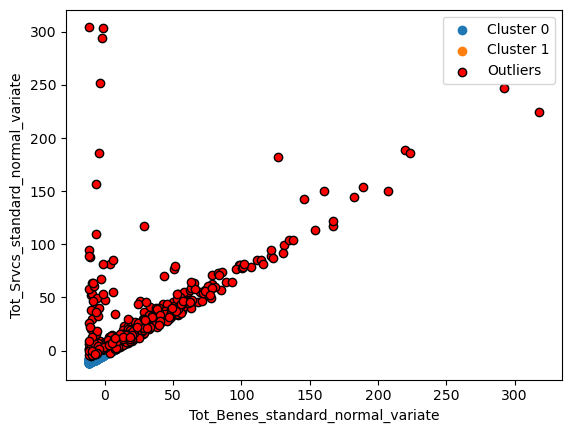

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Assuming you have already run the previous code to generate 'structural_break_data.csv'
data = pd.read_csv('structure_data_outliers_0.05_mean_20_std_20 .csv')

# Apply DBSCAN clustering
X = data[['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate']]
dbscan = DBSCAN(eps=0.7, min_samples=10)  # Adjust eps and min_samples based on your dataset characteristics
labels = dbscan.fit_predict(X)
data['Cluster'] = labels

# Determine far points as outliers
# DBSCAN labels outliers as -1
data['Is_Outlier'] = (data['Cluster'] == -1)

# Plotting 2D scatter plot
plt.figure()

# Plot non-outliers
unique_clusters = set(labels) - {-1}  # Exclude the outlier label which is -1
for cluster_id in unique_clusters:
    cluster_data = data[data['Cluster'] == cluster_id]
    plt.scatter(cluster_data['Tot_Benes_standard_normal_variate'], 
                cluster_data['Tot_Srvcs_standard_normal_variate'], 
                label=f'Cluster {cluster_id}')

# Plot outliers
outliers = data[data['Is_Outlier']]
plt.scatter(outliers['Tot_Benes_standard_normal_variate'], 
            outliers['Tot_Srvcs_standard_normal_variate'], 
            c='red', label='Outliers', edgecolors='black')

# Set the labels for each axis
plt.xlabel('Tot_Benes_standard_normal_variate')
plt.ylabel('Tot_Srvcs_standard_normal_variate')

# Create a legend
plt.legend()

# Show the plot
plt.show()